In [22]:
import os
import json
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import roc_curve

from dataclasses import dataclass
from typing import Dict, List, Optional

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.utils.class_weight import compute_class_weight


In [ ]:

data="voting_fraud_dataset.csv"
df=pd.read_csv(data)
df.head()

,voter_id,age,ip_address,device_id,login_attempts,vote_duration_sec,location_match,previous_votes,is_fraud
0,V0001,32,192.168.0.190,DV1281,4,31,0,0,1
1,V0002,87,192.168.1.152,DV1432,1,6,0,1,1
2,V0003,47,192.168.8.155,DV1027,4,94,1,1,1
3,V0004,75,192.168.9.72,DV1828,1,100,0,3,1
4,V0005,61,192.168.4.40,DV1220,6,16,0,3,1


In [24]:
df.tail()

,voter_id,age,ip_address,device_id,login_attempts,vote_duration_sec,location_match,previous_votes,is_fraud
2995,V2996,39,192.168.1.214,DV1908,1,23,1,1,1
2996,V2997,76,192.168.0.102,DV1409,5,73,0,0,1
2997,V2998,87,192.168.2.70,DV1547,5,48,0,1,1
2998,V2999,18,192.168.8.225,DV1552,4,114,0,2,1
2999,V3000,79,192.168.4.171,DV1834,4,82,1,2,1


In [27]:
print(df["data"].value_counts())

data
voter_id              1
age                   1
ip_address            1
device_id             1
login_attempts        1
voter_duration_sec    1
location_match        1
previous_votes        1
is_fraud              1
Name: count, dtype: int64


In [ ]:
#missing valuse find out
print(df.isnull().sum())


voter_id             0
age                  0
ip_address           0
device_id            0
login_attempts       0
vote_duration_sec    0
location_match       0
previous_votes       0
is_fraud             0
dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   voter_id           3000 non-null   object
 1   age                3000 non-null   int64 
 2   ip_address         3000 non-null   object
 3   device_id          3000 non-null   object
 4   login_attempts     3000 non-null   int64 
 5   vote_duration_sec  3000 non-null   int64 
 6   location_match     3000 non-null   int64 
 7   previous_votes     3000 non-null   int64 
 8   is_fraud           3000 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 211.1+ KB


In [ ]:
#convert object into int
import ipaddress
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df["voter_id"] = le.fit_transform(df["voter_id"])
df["device_id"] = le.fit_transform(df["device_id"])


def ip_to_int(ip):
    return int(ipaddress.ip_address(ip))

df["ip_address"] = df["ip_address"].apply(ip_to_int)
print(df.dtypes)



voter_id             int64
age                  int64
ip_address           int64
device_id            int64
login_attempts       int64
vote_duration_sec    int64
location_match       int64
previous_votes       int64
is_fraud             int64
dtype: object


In [ ]:
#split the data
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [ ]:
#random forest model
model = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# model evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.9977777777777778

Confusion Matrix:
 [[ 51   2]
 [  0 847]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        53
           1       1.00      1.00      1.00       847

    accuracy                           1.00       900
   macro avg       1.00      0.98      0.99       900
weighted avg       1.00      1.00      1.00       900



In [ ]:
#check which featurs are detecting fraud
import pandas as pd

feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(feature_importance)


             Feature  Importance
7     previous_votes    0.439249
4     login_attempts    0.285320
6     location_match    0.169713
5  vote_duration_sec    0.033318
0           voter_id    0.023090
1                age    0.022770
3          device_id    0.018895
2         ip_address    0.007646


In [ ]:
#predict fraud for new voter
new_voter = [[120, 26, 3232235777, 54, 8, 20, 0, 5]]  
# voter_id, age, ip, device, login_attempts, duration, location_match, previous_votes

result = model.predict(new_voter)

if result[0] == 1:
    print(" Fraudulent Vote Detected")
else:
    print(" Vote is Genuine")


 Fraudulent Vote Detected


c:\Users\venka\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


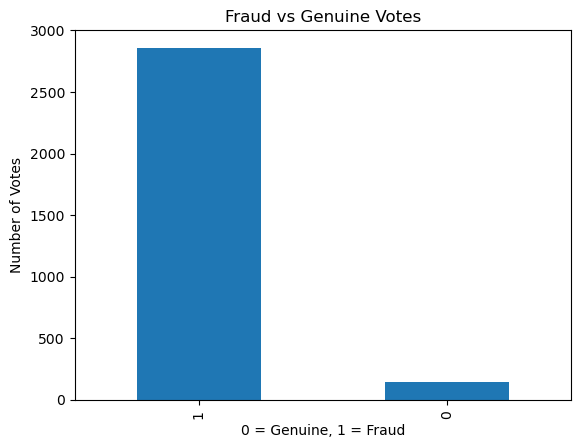

In [ ]:
#Fraud vs Genuine Votes
import matplotlib.pyplot as plt

df["is_fraud"].value_counts().plot(kind="bar")
plt.title("Fraud vs Genuine Votes")
plt.xlabel("0 = Genuine, 1 = Fraud")
plt.ylabel("Number of Votes")
plt.show()


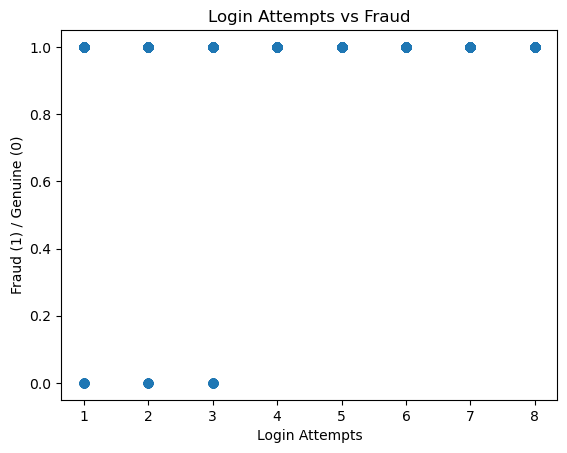

In [ ]:
#Login Attempts vs Fraud
import matplotlib.pyplot as plt

plt.scatter(df["login_attempts"], df["is_fraud"])
plt.title("Login Attempts vs Fraud")
plt.xlabel("Login Attempts")
plt.ylabel("Fraud (1) / Genuine (0)")
plt.show()


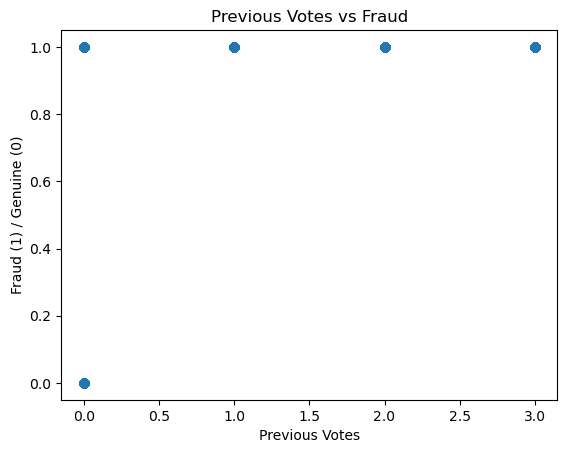

In [ ]:
#Previous Votes vs Fraud
plt.scatter(df["previous_votes"], df["is_fraud"])
plt.title("Previous Votes vs Fraud")
plt.xlabel("Previous Votes")
plt.ylabel("Fraud (1) / Genuine (0)")
plt.show()


In [ ]:
import joblib

joblib.dump(model, "voting_fraud_model.pkl")

print("Model saved successfully!")


Model saved successfully!
